In [1]:
    # Cell 1: Imports
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path
import warnings
import os
import sys
from datetime import datetime
import optuna

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    f1_score, classification_report, roc_auc_score, roc_curve,
    confusion_matrix, accuracy_score, precision_score, recall_score
)

In [2]:
# Cell 2: Setup and Configuration
# ==================================================

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 10

PROJECT_ROOT = Path('../../') 

MODELS_DIR = Path('models')
VIZ_DIR = PROJECT_ROOT / 'visualizations/league_winner'
DATASETS_DIR = PROJECT_ROOT / 'Task_Files/datasets'
RAW_LEAGUE_DATA_PATH = DATASETS_DIR / 'ScoreSight_ML_Season_LeagueWinner_Champion.csv'
FINAL_DATA_PATH = PROJECT_ROOT / 'Task_Files/data/league_winner/league_winner_data.csv'
REPORTS_DIR = PROJECT_ROOT / 'reports/league_winner'

for dir_path in [MODELS_DIR, VIZ_DIR, FINAL_DATA_PATH.parent, REPORTS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
TEST_SIZE = 0.25

print("="*80)
print("SETUP COMPLETED")
print("="*80)
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Project Root (Relative): {PROJECT_ROOT}")
print(f"Models Dir: {MODELS_DIR}")
print(f"Data Path: {RAW_LEAGUE_DATA_PATH}")

SETUP COMPLETED
Timestamp: 2025-12-08 18:41:49
Project Root (Relative): ..\..
Models Dir: models
Data Path: ..\..\Task_Files\datasets\ScoreSight_ML_Season_LeagueWinner_Champion.csv


In [3]:
# Cell 3: Data Loading
# ==================================================

def load_data(file_path):
    print("\n" + "="*80)
    print("DATA LOADING")
    print("="*80)
    
    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_path}")
        
    print(f"\n📂 Loading data from: {file_path}")
    df = pd.read_csv(file_path)
    
    # Standardize column names: lowercase, strip whitespace, replace spaces/dashes with underscores
    df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_').str.replace('-', '_')
    
    print(f"Data Shape: {df.shape}")
    print("\nColumns Overview:")
    print(f"{'Column Name':<30} {'Data Type':<15} {'Non-Null Count'}")
    print("-" * 65)
    for col in df.columns:
        print(f"{col:<30} {str(df[col].dtype):<15} {df[col].count()}")
    
    return df

try:
    df = load_data(RAW_LEAGUE_DATA_PATH)
    
    df.to_csv(FINAL_DATA_PATH, index=False)
    print(f"\n✓ Data saved to {FINAL_DATA_PATH}")
    
except Exception as e:
    print(f"Error loading data: {e}")
    raise e


DATA LOADING

📂 Loading data from: ..\..\Task_Files\datasets\ScoreSight_ML_Season_LeagueWinner_Champion.csv
Data Shape: (180, 16)

Columns Overview:
Column Name                    Data Type       Non-Null Count
-----------------------------------------------------------------
season                         object          180
team                           object          180
matches_played                 int64           180
wins                           int64           180
draws                          int64           180
losses                         int64           180
points_per_game                float64         180
goals_scored                   float64         180
goals_conceded                 float64         180
goal_difference                float64         180
target_total_points            int64           180
target_league_position         int64           180
target_champion                int64           180
target_top_4                   int64           180
target_t

In [4]:
# ==================================================
# Cell 4: Data Cleaning
# ==================================================

print("\n" + "="*80)
print("DATA CLEANING")
print("="*80)

def check_data_quality(df):
    print("Data Shape:", df.shape)
    print("\nMissing Values:\n", df.isnull().sum()[df.isnull().sum() > 0])
    print("\nDuplicate Rows:", df.duplicated().sum())
    
    constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
    if constant_cols:
        print("\nConstant Columns (to drop):", constant_cols)
    else:
        print("\nNo constant columns found.")

check_data_quality(df)

if df.duplicated().sum() > 0:
    print(f"\nRemoving {df.duplicated().sum()} duplicate rows...")
    df = df.drop_duplicates()
    print("Duplicates removed.")


DATA CLEANING
Data Shape: (180, 16)

Missing Values:
 Series([], dtype: int64)

Duplicate Rows: 0

Constant Columns (to drop): ['matches_played']



OUTLIER DETECTION AND REMOVAL
Applying IQR Outlier Removal...
Original Data Shape: (180, 16)
Checking for outliers in 7 columns...
Rows removed: 0
Trimmed Data Shape: (180, 16)

--- Plotting Boxplots for League Winner Data ---


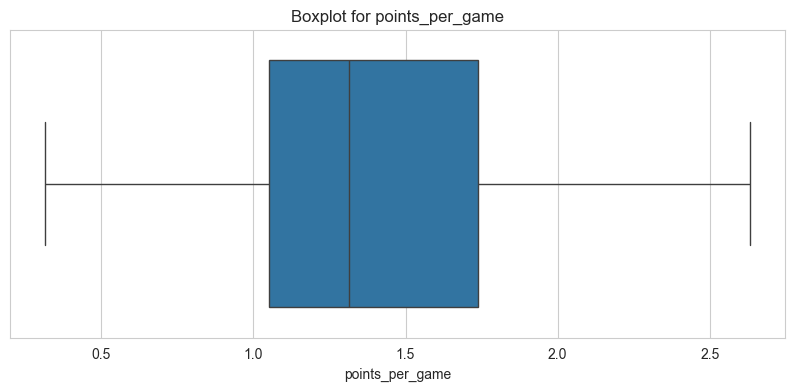

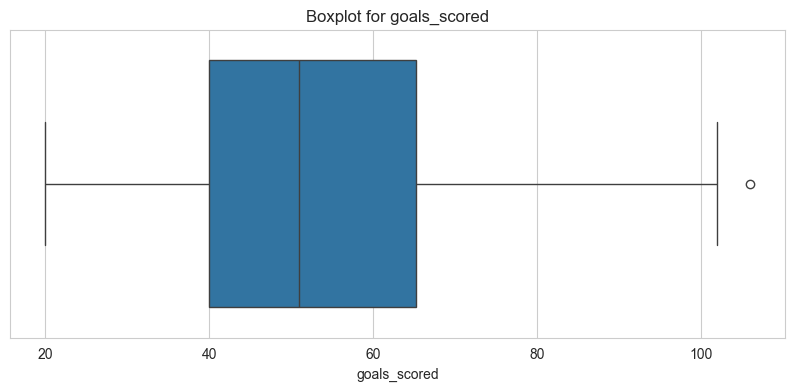

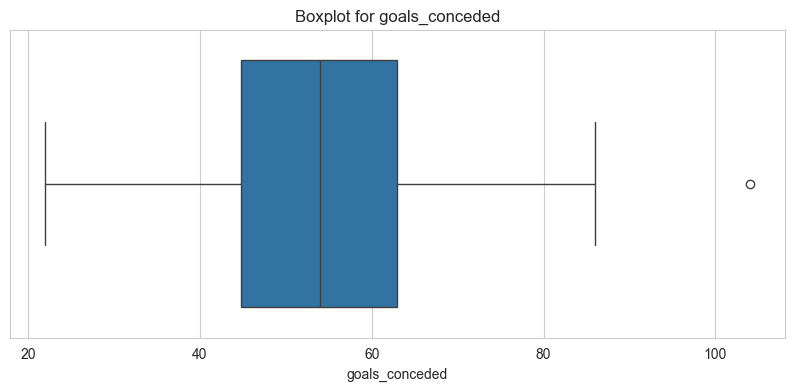

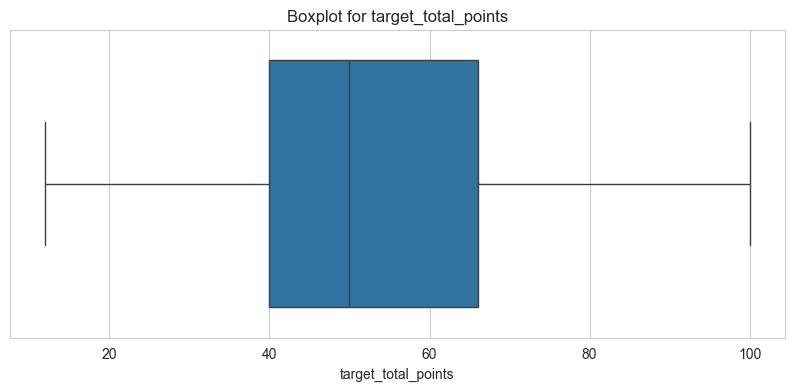

In [5]:
# Cell 4a: Outlier Detection and Removal
# ==================================================

print("\n" + "="*80)
print("OUTLIER DETECTION AND REMOVAL")
print("="*80)

def remove_outliers_iqr(df, multiplier=1.5, target_col='target_champion'):
    """
    Removes outliers from numeric columns using the IQR method.
    Explicitly preserves the minority class (Champions) to prevent data loss.
    """
    df_out = df.copy()
    
    # Select numeric columns
    numeric_cols = df_out.select_dtypes(include=[np.number]).columns
    
    # Identify columns to exclude from outlier detection
    exclude_cols = {target_col}
    exclude_cols.update([c for c in numeric_cols if c.startswith('target_')])
    
    # Exclude low cardinality columns (likely categorical/ordinal)
    for col in numeric_cols:
        if df_out[col].nunique() <= 5:
            exclude_cols.add(col)
            
    cols_to_check = [c for c in numeric_cols if c not in exclude_cols]
    
    print(f"Original Data Shape: {df_out.shape}")
    print(f"Checking for outliers in {len(cols_to_check)} columns...")
    
    if not cols_to_check:
        return df_out

    # Calculate IQR
    Q1 = df_out[cols_to_check].quantile(0.25)
    Q3 = df_out[cols_to_check].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    # Identify outliers
    outliers_mask = ((df_out[cols_to_check] < lower_bound) | (df_out[cols_to_check] > upper_bound)).any(axis=1)
    
    # CRITICAL: Preserve positive class
    if target_col in df_out.columns:
        is_positive = df_out[target_col] == 1
        # We only remove a row if it is an outlier AND it is NOT a champion
        rows_to_remove = outliers_mask & (~is_positive)
        
        preserved_count = (outliers_mask & is_positive).sum()
        if preserved_count > 0:
            print(f"Preserved {preserved_count} outlier rows because they belong to the positive class ('{target_col}').")
    else:
        rows_to_remove = outliers_mask
    
    df_trimmed = df_out[~rows_to_remove]
    
    print(f"Rows removed: {rows_to_remove.sum()}")
    print(f"Trimmed Data Shape: {df_trimmed.shape}")
    
    return df_trimmed

# Apply outlier removal
print("Applying IQR Outlier Removal...")
# Ensure we pass the correct target column name. 
target_column = 'target_champion'
if target_column not in df.columns and 'champion' in df.columns:
    target_column = 'champion'

# Use a less aggressive multiplier (3.0) to preserve more data in this small dataset
df = remove_outliers_iqr(df, multiplier=3.0, target_col=target_column)

# Plotting BoxPlots
print("\n--- Plotting Boxplots for League Winner Data ---")
numeric_cols = df.select_dtypes(include=[np.number]).columns
cols_to_plot = [c for c in numeric_cols if 'points' in c or 'goals' in c][:5]

for col in cols_to_plot:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.xlabel(col)
    plt.show()


EXPLORATORY DATA ANALYSIS


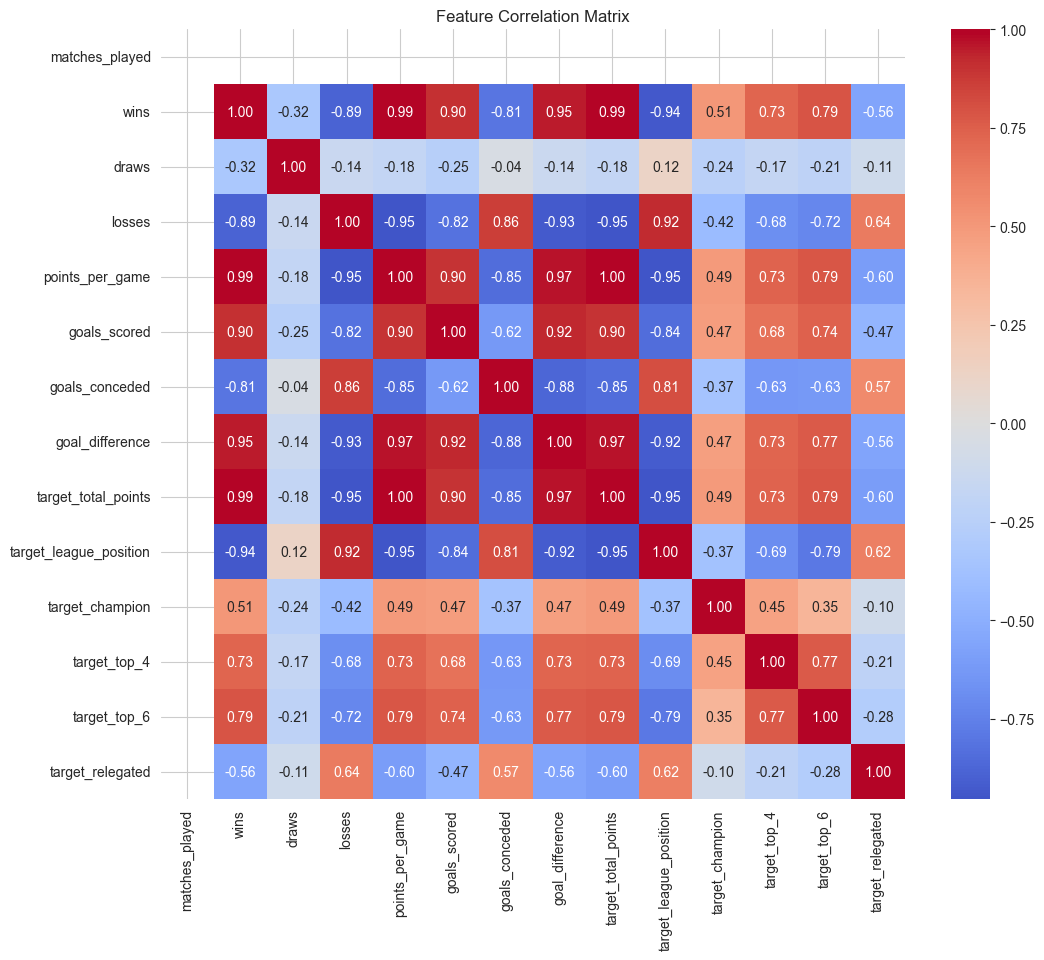

In [6]:
# Cell 5: Exploratory Data Analysis (EDA)
# ==================================================

def perform_eda(df, target_col='champion'):
    print("\n" + "="*80)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*80)
    
    if target_col in df.columns:
        print(f"\nTarget Distribution ({target_col}):")
        print(df[target_col].value_counts(normalize=True))
        
        plt.figure(figsize=(6, 4))
        sns.countplot(x=target_col, data=df)
        plt.title(f'Distribution of {target_col}')
        plt.show()
    
    numeric_df = df.select_dtypes(include=[np.number])
    if not numeric_df.empty:
        plt.figure(figsize=(12, 10))
        correlation_matrix = numeric_df.corr()
        
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title('Feature Correlation Matrix')
        plt.show()
        
        if target_col in numeric_df.columns:
            print(f"\nTop Correlations with {target_col}:")
            print(correlation_matrix[target_col].sort_values(ascending=False).head(10))
            print(correlation_matrix[target_col].sort_values(ascending=False).tail(5))

perform_eda(df, target_col='rank')

In [7]:
# Cell 7: Feature Engineering and Preprocessing
# ==================================================

try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMB_AVAILABLE = True
    print("SMOTE is available.")
except ImportError:
    print("Installing imbalanced-learn...")
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'imbalanced-learn'])
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMB_AVAILABLE = True
    print("SMOTE installed and available.")

def preprocess_features(df, target_col='champion', drop_cols=None):
    print("\n" + "="*80)
    print("FEATURE ENGINEERING AND SPLITTING")
    print("="*80)
    
    data = df.copy()
    
    if target_col not in data.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataset.")

    y = data[target_col]
    X = data.drop(columns=[target_col])

    if drop_cols:
        dropped = [c for c in drop_cols if c in X.columns]
        X = X.drop(columns=drop_cols, errors='ignore')
        
    print(f"Selected Feature Columns ({len(X.columns)}):")
    
    # Splitting Strategy
    if 'season' in df.columns:
        print("\nUsing Temporal Split based on 'season'...")
        seasons = sorted(df['season'].unique())
        
        # Use 75% of seasons for training (approx matching user request)
        split_idx = int(len(seasons) * 0.75) 
        # Ensure at least one season in test
        if split_idx >= len(seasons):
            split_idx = len(seasons) - 1
            
        train_seasons = seasons[:split_idx]
        test_seasons = seasons[split_idx:]
        
        print(f"Training Seasons: {train_seasons}")
        print(f"Test Seasons: {test_seasons}")
        
        train_indices = df['season'].isin(train_seasons)
        test_indices = df['season'].isin(test_seasons)

        X_train = X[train_indices]
        y_train = y[train_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]
        
        if 'season' in X_train.columns:
            X_train = X_train.drop(columns=['season'])
            X_test = X_test.drop(columns=['season'])
    else:
        print("\nUsing Random Stratified Split...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
        )
        
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    
    # SMOTE Logic
    if IMB_AVAILABLE:
        print("\nApplying SMOTE to handle class imbalance...")
        
        # Check class distribution
        class_counts = y_train.value_counts()
        if len(class_counts) < 2:
             # Fallback: If temporal split resulted in no champions in training, we can't use SMOTE.
             # This shouldn't happen if data is distributed correctly, but as a safety net:
             print("⚠ Warning: Training set has only 1 class. Cannot apply SMOTE.")
             X_train_resampled, y_train_resampled = X_train_scaled, y_train
        else:
            # Adjust k_neighbors if samples are few
            n_minority = class_counts.min()
            k_neighbors = min(5, n_minority - 1)
            
            if k_neighbors < 1:
                 print("⚠ Warning: Not enough minority samples for SMOTE.")
                 X_train_resampled, y_train_resampled = X_train_scaled, y_train
            else:
                smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=k_neighbors)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
                
                print(f"Original training shape: {X_train_scaled.shape}")
                print(f"Resampled training shape: {X_train_resampled.shape}")
                print(f"Original target distribution:\n{y_train.value_counts(normalize=True)}")
                print(f"Resampled target distribution:\n{y_train_resampled.value_counts(normalize=True)}")
    else:
        print("\nSMOTE not available. Using original data.")
        X_train_resampled, y_train_resampled = X_train_scaled, y_train
    
    print(f"\nTraining Shape: {X_train_resampled.shape}")
    print(f"Testing Shape: {X_test_scaled.shape}")
    
    return X_train_resampled, X_test_scaled, y_train_resampled, y_test, scaler

DROP_COLS = ['team', 'team_name', 'date', 'matches_played', 'target_total_points', 
             'target_league_position', 'target_top_4', 'target_top_6', 'target_relegated', 'goal_difference'] 

target = 'target_champion'
print(f"\nUsing target column: '{target}'")
X_train, X_test, y_train, y_test, scaler = preprocess_features(df, target_col=target, drop_cols=DROP_COLS)

SMOTE is available.

Using target column: 'target_champion'

FEATURE ENGINEERING AND SPLITTING
Selected Feature Columns (7):

Using Temporal Split based on 'season'...
Training Seasons: ['2015-16', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22']
Test Seasons: ['2022-23', '2023-24', '2024-25']

Applying SMOTE to handle class imbalance...
Original training shape: (120, 6)
Resampled training shape: (228, 6)
Original target distribution:
target_champion
0    0.95
1    0.05
Name: proportion, dtype: float64
Resampled target distribution:
target_champion
0    0.5
1    0.5
Name: proportion, dtype: float64

Training Shape: (228, 6)
Testing Shape: (60, 6)
Original training shape: (120, 6)
Resampled training shape: (228, 6)
Original target distribution:
target_champion
0    0.95
1    0.05
Name: proportion, dtype: float64
Resampled target distribution:
target_champion
0    0.5
1    0.5
Name: proportion, dtype: float64

Training Shape: (228, 6)
Testing Shape: (60, 6)


In [8]:
# Cell 8: Model Training and Hyperparameter Tuning
# ==================================================

try:
    import xgboost as xgb
    XGB_AVAILABLE = True
    print("XGBoost is available.")
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost not installed. Skipping XGBoost model.")

def tune_hyperparameters(model_class, X_train, y_train, param_fn, n_trials=50, cv=5, scoring='f1_weighted', task_type='classification'):
    # Suppress Optuna logging to keep output clean
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    def objective(trial):
        params = param_fn(trial)
        model = model_class(**params)
        
        if task_type == 'classification':
            cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
        else:
            cv_strategy = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
            
        scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring=scoring, n_jobs=-1)
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
        
    return study.best_params

def train_models(X_train, y_train):
    print("\n" + "="*80)
    print("MODEL TRAINING AND TUNING")
    print("="*80)
    
    best_models = {}
    
    print("\n--- Tuning Random Forest ---")
    def rf_params(trial):
        return {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        }
    
    rf_best_params = tune_hyperparameters(
        RandomForestClassifier, X_train, y_train, rf_params, n_trials=50, scoring='f1_weighted'
    )
    
    rf_model = RandomForestClassifier(**rf_best_params)
    rf_model.fit(X_train, y_train)
    best_models['RandomForest'] = rf_model
    
    print("\n--- Tuning Gradient Boosting (Sklearn) ---")
    def gb_params(trial):
        return {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'random_state': RANDOM_STATE
        }
        
    gb_best_params = tune_hyperparameters(
        GradientBoostingClassifier, X_train, y_train, gb_params, n_trials=50, scoring='f1_weighted'
    )
    
    gb_model = GradientBoostingClassifier(**gb_best_params)
    gb_model.fit(X_train, y_train)
    best_models['GradientBoosting'] = gb_model

    if XGB_AVAILABLE:
        print("\n--- Tuning XGBoost ---")
        def xgb_params(trial):
            return {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'random_state': RANDOM_STATE,
                'n_jobs': -1,
                'eval_metric': 'logloss'
            }
            
        xgb_best_params = tune_hyperparameters(
            xgb.XGBClassifier, X_train, y_train, xgb_params, n_trials=50, scoring='f1_weighted'
        )
        
        xgb_model = xgb.XGBClassifier(**xgb_best_params)
        xgb_model.fit(X_train, y_train)
        best_models['XGBoost'] = xgb_model
        
    return best_models

best_models = train_models(X_train, y_train)

XGBoost is available.

MODEL TRAINING AND TUNING

--- Tuning Random Forest ---
Best trial:
  Value: 0.9867347742879659
  Params: 
    n_estimators: 243
    max_depth: 12
    min_samples_split: 2
    min_samples_leaf: 1
    class_weight: balanced_subsample

--- Tuning Gradient Boosting (Sklearn) ---
Best trial:
  Value: 0.9867347742879659
  Params: 
    n_estimators: 443
    learning_rate: 0.020538654492396887
    max_depth: 6
    subsample: 0.6555601600169971
    max_features: None

--- Tuning XGBoost ---
Best trial:
  Value: 0.9867347742879659
  Params: 
    n_estimators: 109
    max_depth: 3
    learning_rate: 0.20000083754385284
    subsample: 0.9753095797373628
    colsample_bytree: 0.9886961078146258



MODEL EVALUATION
Evaluating models...

🏆 Best Model: RandomForest (F1 Score: 0.9577)
----------------------------------------
--- RandomForest Evaluation ---
Accuracy: 0.9500
Precision (Weighted): 0.9750
Recall (Weighted): 0.9500
F1 Score (Weighted): 0.9577
ROC AUC: 0.9825

Classification Report:

              precision    recall  f1-score   support

Not Champion       1.00      0.95      0.97        57
    Champion       0.50      1.00      0.67         3

    accuracy                           0.95        60
   macro avg       0.75      0.97      0.82        60
weighted avg       0.97      0.95      0.96        60



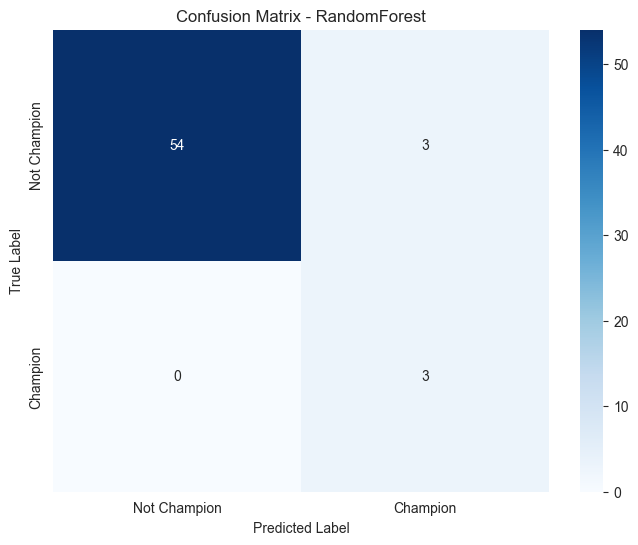


Feature Importance for RandomForest:


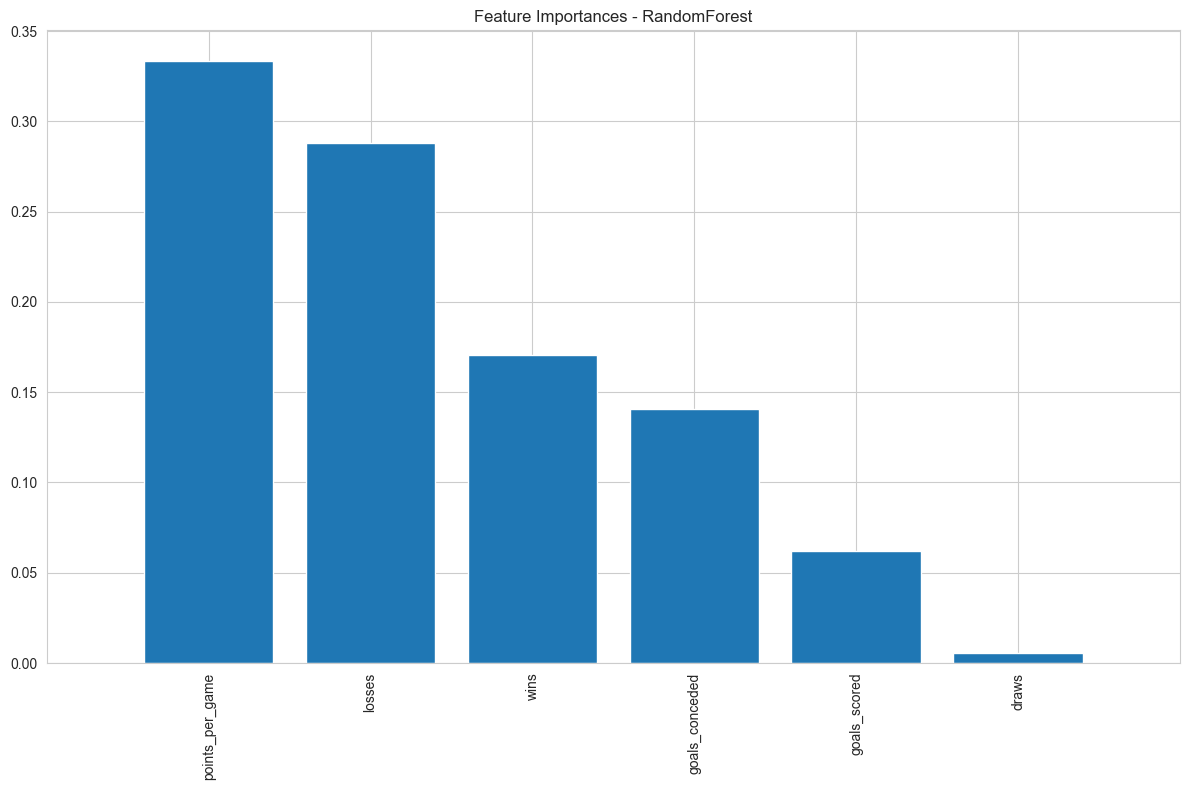

✓ Best model saved to models\league_winner_RandomForest.joblib


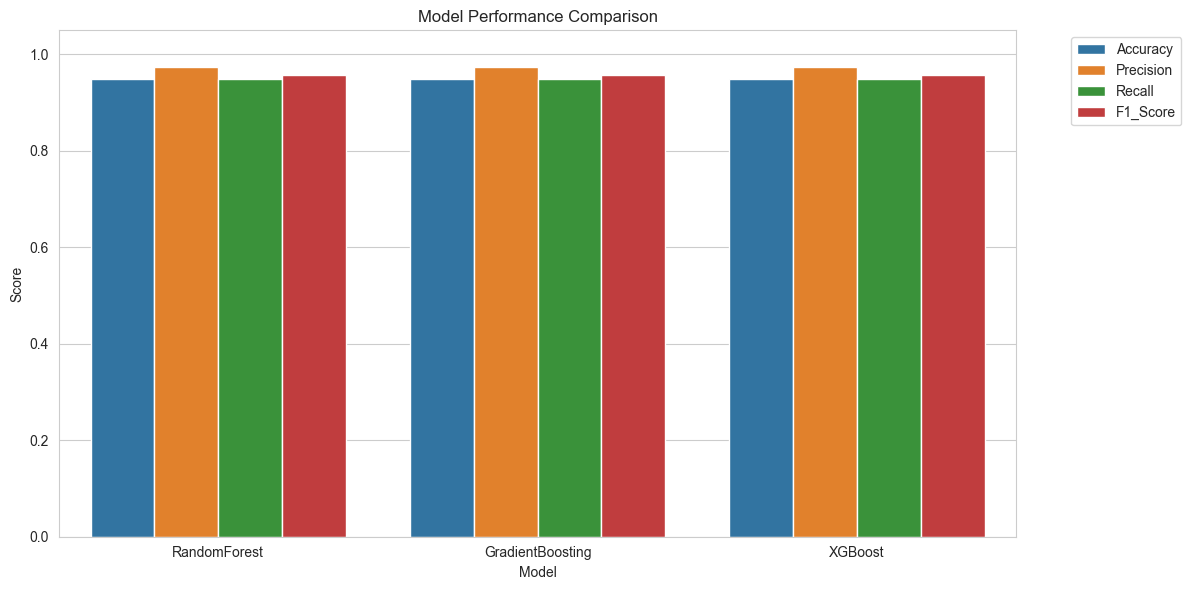


MODEL COMPARISON TABLE
           Model  Accuracy  Precision  Recall  F1_Score
    RandomForest      0.95      0.975    0.95  0.957658
GradientBoosting      0.95      0.975    0.95  0.957658
         XGBoost      0.95      0.975    0.95  0.957658

✓ Comparison saved to: ..\..\reports\league_winner\model_comparison.csv


In [9]:
# Cell 9: Model Evaluation
# ==================================================

print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80)

def evaluate_classification_model(model, X_test, y_test, model_name="Model", class_names=None):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"--- {model_name} Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")
    
    if y_prob is not None and len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_prob[:, 1])
        print(f"ROC AUC: {roc_auc:.4f}")
    
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    }

def plot_feature_importance(model, feature_names, top_n=20, model_name="Model"):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        n_features = len(feature_names)
        top_n = min(top_n, n_features)
        
        plt.figure(figsize=(12, 8))
        plt.title(f"Feature Importances - {model_name}")
        plt.bar(range(top_n), importances[indices[:top_n]], align="center")
        plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=90)
        plt.xlim([-1, top_n])
        plt.tight_layout()
        plt.show()
    else:
        print(f"{model_name} does not support feature importance plotting.")

results = []
class_names = ['Not Champion', 'Champion']
best_score = -1
best_model_name = None
best_model_instance = None

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

print("Evaluating models...")
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1_Score': f1
    })
    
    if f1 > best_score:
        best_score = f1
        best_model_name = name
        best_model_instance = model

print(f"\n🏆 Best Model: {best_model_name} (F1 Score: {best_score:.4f})")
print("-" * 40)
evaluate_classification_model(best_model_instance, X_test, y_test, model_name=best_model_name, class_names=class_names)

print(f"\nFeature Importance for {best_model_name}:")
plot_feature_importance(best_model_instance, X_train.columns, model_name=best_model_name)

model_path = MODELS_DIR / f'league_winner_{best_model_name}.joblib'
joblib.dump(best_model_instance, model_path)
print(f"✓ Best model saved to {model_path}")

results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("MODEL COMPARISON TABLE")
print("="*80)
print(results_df.to_string(index=False))
results_df.to_csv(REPORTS_DIR / 'model_comparison.csv', index=False)
print(f"\n✓ Comparison saved to: {REPORTS_DIR / 'model_comparison.csv'}")

In [10]:
# Cell 10: Final Summary Report
# ==================================================

print("\n" + "="*80)
print("PIPELINE SUMMARY")
print("="*80)

best_model_name = results_df.loc[results_df['F1_Score'].idxmax(), 'Model']
best_model = best_models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1 Score: {results_df.loc[results_df['Model'] == best_model_name, 'F1_Score'].values[0]:.4f}")

best_model_path = MODELS_DIR / f'ps1_league_winner_best_model.joblib'
joblib.dump(best_model, best_model_path)
print(f"\n✓ Best model saved to: {best_model_path}")

metadata = {
    'pipeline': 'League Winner Prediction',
    'problem_statement': 'PS1 - League Winner',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'best_model': best_model_name,
    'metrics': results_df[results_df['Model'] == best_model_name].to_dict('records')[0],
    'all_results': results_df.to_dict('records'),
    'features_used': X_train.columns.tolist(),
    'target_column': target,
    'random_state': RANDOM_STATE,
    'test_size': TEST_SIZE
}

import json
metadata_path = MODELS_DIR / 'ps1_league_winner_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print(f"✓ Metadata saved to: {metadata_path}")

print("\n" + "="*80)
print("✅ LEAGUE WINNER PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"\nOutput Locations:")
print(f"  🤖 Models: {MODELS_DIR}")
print(f"  📄 Reports: {REPORTS_DIR}")
print(f"  📊 Visualizations: {VIZ_DIR}")
print(f"  💾 Processed Data: {FINAL_DATA_PATH}")


PIPELINE SUMMARY

🏆 Best Model: RandomForest
   F1 Score: 0.9577

✓ Best model saved to: models\ps1_league_winner_best_model.joblib
✓ Metadata saved to: models\ps1_league_winner_metadata.json

✅ LEAGUE WINNER PIPELINE COMPLETED SUCCESSFULLY!

Output Locations:
  🤖 Models: models
  📄 Reports: ..\..\reports\league_winner
  📊 Visualizations: ..\..\visualizations\league_winner
  💾 Processed Data: ..\..\Task_Files\data\league_winner\league_winner_data.csv
